In [7]:
from __future__ import division
from pyomo.opt import SolverFactory
from pyomo.environ import *
import time
import datetime
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
import seaborn as sns
from pyomo.opt import SolverStatus, TerminationCondition

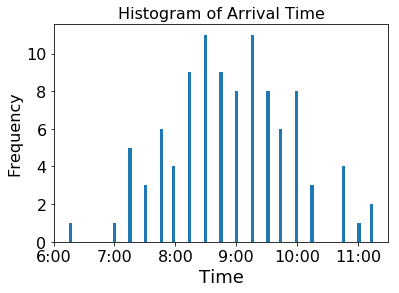

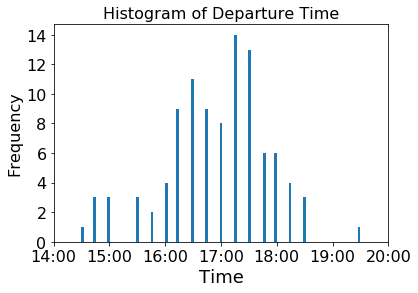

In [39]:
# Assume everyday the departure time and arrival time follows normal
# distribution (8:00, -10:00) departure time (4:00- 6:00)

#generate start time and end time for 100 EVs
# Truncated normal distribution 
lower_arr, upper_arr = 24, 48
mu_arr, sigma_arr = 36, 4
samples_arr = stats.truncnorm.rvs(
          (lower_arr-mu_arr)/sigma_arr,(upper_arr-mu_arr)/sigma_arr,loc=mu_arr,scale=sigma_arr,size=100)
ArrTime = np.round(samples_arr)

plt.hist(ArrTime, bins=97)  # plt.hist passes it's arguments to np.histogram
plt.title("Histogram of Arrival Time", fontsize=16)
plt.xticks(np.arange(24,45,4),('6:00','7:00','8:00','9:00','10:00','11:00'), fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.show()

lower_dep, upper_dep = 56, 80
mu_dep, sigma_dep = 68, 4
samples_dep = stats.truncnorm.rvs(
          (lower_dep-mu_dep)/sigma_dep,(upper_dep-mu_dep)/sigma_dep,loc=mu_dep,scale=sigma_dep,size=100)
DepTime = np.round(samples_dep)

plt.hist(DepTime, bins=97)  # plt.hist passes it's arguments to np.histogram
plt.title("Histogram of Departure Time", fontsize=16)
plt.xticks(np.arange(56,81,4),('14:00','15:00','16:00','17:00','18:00','19:00','20:00'), fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.show()

# # uniform distribution
# ArrTime = [round(i) for i in np.random.normal(31,41,100)]
# DepTime = [round(i) for i in np.random.normal(63,73,100)]

TimeTable = pd.DataFrame({'Arrival time': ArrTime, 'Departure time': DepTime})

# Create the 0-1 table to show the plug-in time
PlugTime = [[0 for i in range(96)] for j in range(100)]
for x in range(100):
    index = 0
    while index < 96:
        if index > TimeTable['Arrival time'].iloc[x] and index < TimeTable['Departure time'].iloc[x]:
            PlugTime[x][index] = 1
        else:
            PlugTime[x][index] = 0
        index += 1

PlugTimeTable = pd.DataFrame(PlugTime)

In [ ]:
# calculate energy consumption of each EV
lower_con, upper_con = 8, 80
mu_con, sigma_con = 20, 8
samples_con = stats.truncnorm.rvs(
          (lower_con-mu_con)/sigma_con,(upper_con-mu_con)/sigma_con,loc=mu_con,scale=sigma_con,size=100)
energy_consump = {k: v for k, v in enumerate(samples_con/3.75)}

In [ ]:
# #calculate uncontroll charging load
# energy_consump = np.random.uniform(5/3.75, 40/3.75, 50)

charge_activity = [[0 for i in range(96)] for j in range(100)]
cum_energy = 0
for i in range(100):
    for j in range(96):
        if PlugTimeTable.iloc[i][j] == 1 and energy_consump[i] - cum_energy >= 6.6/4:
            charge_activity[i][j] = 6.6
            cum_energy += 6.6/4
            
        elif PlugTimeTable.iloc[i][j] == 1 and cum_energy < energy_consump[i] and energy_consump[i] - cum_energy <6.6/4:
            charge_activity[i][j] = (energy_consump[i] - cum_energy) * 4
            cum_energy = 0
            break
        else:
            charge_activity[i][j] = 0
    
EV_Load = pd.DataFrame(charge_activity).sum(axis = 0)
EV_Load.plot()
plt.xlabel("Time") 
plt.ylabel("load")
plt.show()

In [ ]:
# Load the load and price data
opt_input = pd.read_excel('data.xlsx', sheetname=0, header=0, index_col=None)
Building_load = opt_input['Demand (kW)']

Building_load.to_dict()

total_load = EV_Load + Building_load
total_load.plot()
Building_load.plot()
plt.xlabel("Time") 
plt.ylabel("load")
plt.show()

In [ ]:
def Co_optimization(inputfile, TimeTable, energydemand, solver="gurobi"):
    # Read all price data

    price = inputfile['Energy Price ($/kWh)'].to_dict()
    netload = inputfile['Demand (kW)'].to_dict()
    


    with SolverFactory(solver) as opt:
        # Creation of a Concrete Model
            model = ConcreteModel()


            # ###### Set
            model.t = Set(initialize=range(96), doc = 'Time')
            model.v = Set(initialize=range(100), doc='Vehicles')

            # ###### Parameters

            # Price, load, required energy
            model.price_energy = Param(model.t, initialize=price, doc='Energy Price')
            model.net_load = Param(model.t, initialize = netload, doc = 'net load')
            model.energy_demand = Param(model.v, initialize = energydemand, doc = 'required energy')


            # ###### Variable
            model.energy_charge = Var(model.t, model.v, domain=NonNegativeReals, doc='charge power')
            model.D = Var(domain = NonNegativeReals, doc = 'added demand charge cost')


            # ###### Rules
            def maximum_chargepower_rule(model, t, v):
                return model.energy_charge[t,v] <= 6.6
            model.chargepower_max_rule1 = Constraint(model.t, model.v, rule=maximum_chargepower_rule, doc='Pcharge max rule')


            def final_energy_balance(model, v):
                return sum(model.energy_charge[i,v] * TimeTable[i][v] for i in model.t)/4 >= model.energy_demand[v]
            model.final_energy_rule = Constraint(model.v, rule=final_energy_balance, doc='E final rule')


            def demand_charge_rule(model, t):
                return 18.74 * (sum(model.energy_charge[t,v] for v in model.v) + model.net_load[t]) <= model.D
            model.demand_charge_rule = Constraint(model.t, rule=demand_charge_rule, doc='cannot exceed demand charge')

            def objective_rule(model):
                return sum(model.price_energy[t] * (sum(model.energy_charge[t,v]  for v in model.v) +  model.net_load[t])/4 
                           for t in model.t) * 30 + model.D
            model.objective = Objective(rule=objective_rule, sense=minimize, doc='Define objective function')
            

            results = opt.solve(model)
            result_charge = []


            for i in model.energy_charge:
                result_charge.append(value(model.energy_charge[i]))
            opt_charge = np.reshape(result_charge, (96, 100))
            optimalresult = pd.DataFrame(opt_charge)


            print value(model.objective)
            print value(model.D)
#             model.load(results) # Loading solution into results object

#             if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
#                 print 'Got the optimal solution!'
#             elif (results.solver.termination_condition == TerminationCondition.infeasible):
#                 print 'No infeasible solution!'
#             else:
#                 # Something else is wrong
#                 print ('Solver Status:', results.solver.status)


    return optimalresult

In [ ]:
# # Optimization to minimize energy cost and demand charge
myresult = Co_optimization(opt_input, PlugTimeTable, energy_consump)
a = myresult.sum(axis = 1)
total_load_new = a + Building_load
total_load_new.plot()
Building_load.plot()
plt.xlabel("Time") 
plt.ylabel("load")
plt.show()

In [ ]:
max(total_load_new)

In [ ]:
max(total_load)

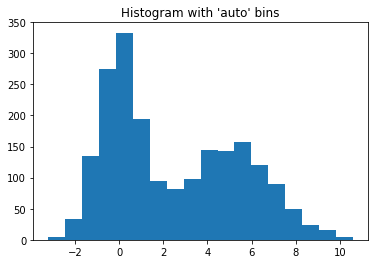

In [3]:
import matplotlib.pyplot as plt
rng = np.random.RandomState(10)  # deterministic random data
a = np.hstack((rng.normal(size=1000),rng.normal(loc=5, scale=2, size=1000)))
plt.hist(a, bins='auto')  # plt.hist passes it's arguments to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

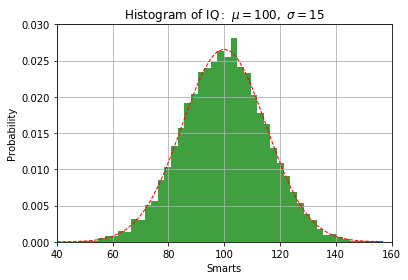

In [10]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

mu, sigma = 100, 15
x = mu + sigma*np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

In [8]:
rng = np.random.RandomState(10)
print rng

In [5]:
np.arange(6)

array([0, 1, 2, 3, 4, 5])

In [10]:
datetime.time

datetime.time

In [33]:
np.arange(0,96)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])